<a href="https://colab.research.google.com/github/anarakinson/cameras-verification-OCR/blob/main/Verification_OCR_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Задаем глобальные переменные
img_width, img_height = 128, 128  # Размеры изображений
batch_size = 16  
characters = [str(i) for i in range(10)]     # Возможные символы (цифры), встречающиеся в разметке

# Создаем датасет

## Создаем первичные выборки картинок и лэйблов

Поскольку для данной модели будет использоваться tfdata - нам потребуются только названия изображений

In [ ]:
# Для того, чтобы порядок кадров совпадал с порядком разметки необходимо 
# отсортировать все дирректории. 
# Кроме того, не все папки с кадрами были размечены и очищены.

list_of_markups = []

path0 = '/content/drive/MyDrive/Colab_Files/videos/'

for i in os.listdir(path0):
  if '.txt' in i:
    print(i)
    i = i.replace('labels', '')
    i = i.replace('.txt', '')
    list_of_markups.append(int(i))
    
list_of_markups = sorted(list_of_markups)
list_of_markups

labels1.txt
labels4.txt
labels12.txt
labels3.txt
labels2.txt
labels8.txt
labels22.txt
labels17.txt
labels24.txt
labels28.txt
labels29.txt
labels27.txt
labels26.txt
labels30.txt
labels31.txt
labels32.txt
labels33.txt
labels40.txt


[1, 2, 3, 4, 8, 12, 17, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 40]

In [ ]:
images = []
labels = []

for i in list_of_markups:         # Пробегаем по номерам из списка размеченных папок
  path = path0 + 'markup0' + str(i) + '/'     # И создаем путь до каждой из них
  directory = [int(i.replace('.png','')) for i in os.listdir(path)]
  directory = sorted(directory)         # Сортируем файлы внутри директориии

  for obj in directory:            # Пробегаем по всем файлам в директории
    images.append(path + str(obj) + '.png')  # Добавляем путь к файлу и его название в список
    
  with open(path0 + 'labels' + str(i) + '.txt', 'r') as f:
    for line in f:                                  
      labels.append(line.strip().replace('.', ''))  # Добавляем цифры из разметки в y_train (без точек)

  print(i, '- done, len:', len(images), len(labels)) # Выводим прогресс на экран

1 - done, len: 179 179
2 - done, len: 398 398
3 - done, len: 548 548
4 - done, len: 793 793
8 - done, len: 1233 1233
12 - done, len: 1558 1558
17 - done, len: 1776 1776
22 - done, len: 2152 2152
24 - done, len: 2637 2637
26 - done, len: 3345 3345
27 - done, len: 3594 3594
28 - done, len: 3950 3950
29 - done, len: 4685 4685
30 - done, len: 4870 4870
31 - done, len: 5242 5242
32 - done, len: 5680 5680
33 - done, len: 6056 6056
40 - done, len: 6247 6247


## Предобработка данных

In [ ]:
max_length = max([len(label) for label in labels]) # Максимальное количество цифр на изображении

# Переводим разметку в числовой формат
char_to_num = experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Переводим числа из разметки обратно в строковый формат
num_to_char = experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Получаем полный размер датасета
    size = len(images)
    # 2. Индексируем элементы датасета и перемешиваем их
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Определяем тренеровочную выборку
    train_samples = int(size * train_size)
    # 4. Разделяем датасет на тренеровочную и валидационную выборки
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Разделяем датасет на тренеровочную и валидационную выборки
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Загружаем изображение
    img = tf.io.read_file(img_path)
    # 2. Преобразуем в массив с одним каналом
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Подгоняем под нужный размер
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Поворачиваем изображение набок
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Преобразуем разметку в числовое представление
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Возвращаем словарь с изображениями и лэйблами для двух входов модели
    return {"image": img, "label": label}

In [ ]:
# Примеры из выборок
x_train[0], y_train[0]

('/content/drive/MyDrive/Colab_Files/videos/markup028/959.png', '032958813')

## Создаем Tensorflow Datasets

In [ ]:
# Создаем тренировочный датасет из данных на диске посредством tf.data
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample,  # Предобрабатываем каждое изображение и лэйбл с диска
                      num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)   # Разбиваем на батчи
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # Создаем буферную зону для контрольных точек
)                         # чтобы иметь возможность восстановить последнюю контрольную точку для восстановления прогресса.

# Создаем валидационный датасет из данных на диске посредством tf.data
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_single_sample,  # Предобрабатываем каждое изображение и лэйбл с диска
                           num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)   # Разбиваем на батчи
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # Создаем буферную зону для контрольных точек
)                         # чтобы иметь возможность восстановить последнюю контрольную точку для восстановления прогресса.

## Визуализация данных

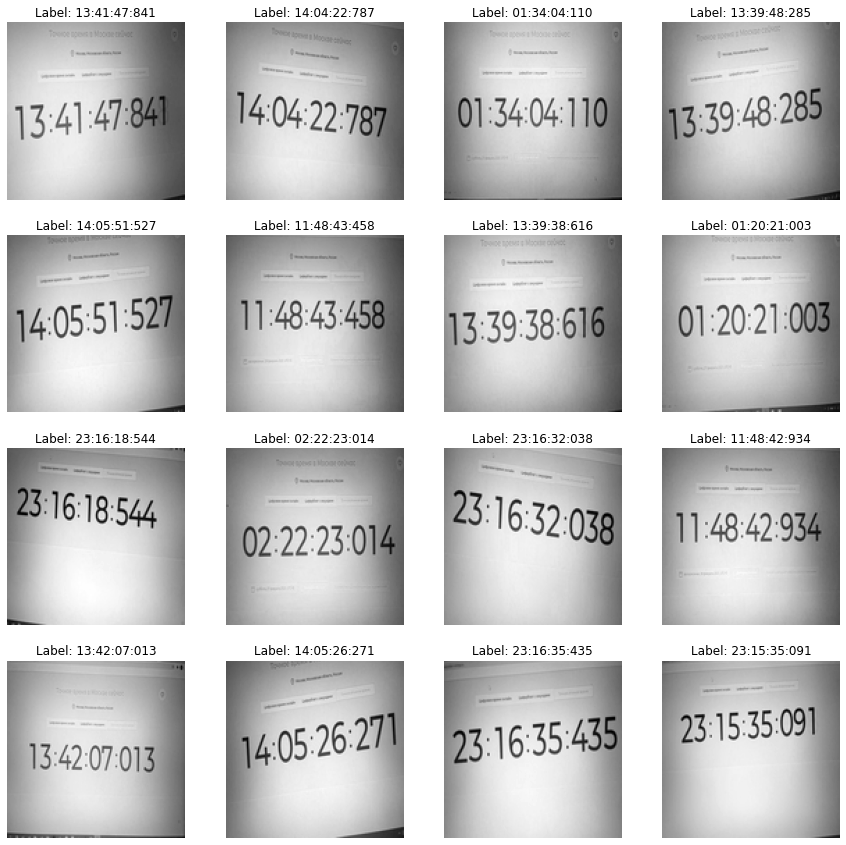

In [ ]:
# Посмотрим на примеры из выборок
_, ax = plt.subplots(4, 4, figsize=(15, 15))
for batch in train_dataset.take(1):  # Пробегаем по батчам в датасете
    images = batch["image"]   # Достаем из датасета изображения
    labels = batch["label"]   # и разметку
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")  # Восстанавливаем и переводим в целочисленное представление
        h1, h2, m1, m2, s1, s2, s3, s4, s5 = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        title = f"Label: {h1+h2+':'+m1+m2+':'+s1+s2+':'+s3+s4+s5}"  # Переводим разметку в строковый вид и разделяем двоеточиями
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(title)   # Выводим изображение и над ним разметку
        ax[i // 4, i % 4].axis("off")
plt.show()

# Модель

Для создания OCR (Оptical character recognition) модели воспользуемся Connectionist temporal classification (CTC)

это тип выходных слоёв нейронных сетей и связанная с ним функция оценки для обучения рекуррентных нейронных сетей (RNN), таких как сети LSTM, для решения проблем с последовательностью, где выход является переменным. Этот метод используют для таких задач, как распознавание рукописного текста или распознавание фонем в звуковой речи. CTC относится к выходным данным и оценке и не зависит от базовой структуры нейронной сети. Метод был представлен в 2006 году.

Входными данными является последовательность наблюдений, а выходными данными - последовательность меток, которые могут включать пустые выходные данные. Сложность обучения возникает из-за того, что наблюдений гораздо больше, чем ярлыков. Например, в звуковой речи может быть несколько отрезков времени, соответствующих одной фонеме. Поскольку мы не знаем выравнивания наблюдаемой последовательности с целевыми метками, мы прогнозируем распределение вероятностей на каждом временном шаге. Сеть CTC имеет непрерывный вывод (например, softmax), который настраивается путем обучения для моделирования вероятности метки. CTC не пытается узнать границы и время: последовательности меток считаются эквивалентными, если они различаются только выравниванием, игнорируя пробелы. Эквивалентные последовательности меток могут возникать по-разному, что делает оценку нетривиальной задачей, но для этого существует эффективный Алгоритм прямого-обратного хода (Forward–backward algorithm).

In [ ]:
class CTCLayer(Layer):
    # Connectionist temporal classification (CTC)
    # Выходной слой использующий систему СТС
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost # Применяет CTC-loss для каждого элемента минибатча

    def call(self, y_true, y_pred):
        # Высчитываем лосс на тренировочной выборке
        # и добавляем его в слой методом `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # Для валидации просто возвращаем уже выссчитанное предсказание
        return y_pred


def build_model():
    # Входные слои для изображения и для лейбла раздельно
    input_img = Input((img_width, img_height, 1), 
                      name="image", dtype="float32")
    labels = Input(shape=(None,), name="label", dtype="float32")

    # Первый сверточный блок
    x = Conv2D(32, (3, 3), activation="relu",
        kernel_initializer="he_normal",
        padding="same", name="Conv1")(input_img)
    x = MaxPooling2D((2, 2), name="pool1")(x)

    # Второй сверточный блок
    x = Conv2D(64, (3, 3), activation="relu",
        kernel_initializer="he_normal",
        padding="same", name="Conv2")(x)
    x = MaxPooling2D((2, 2), name="pool2")(x)

    # Мы используем два MaxPooling-слоя с окном  2х2.
    # Следовательно, получаем feature maps четырёхкратно уменшенными. 
    # Количество фильтров на выходе сверточных блоков - 64.
    # Реформируем в двухмерный массив, чтобы передать в RNN-слои
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = Reshape(target_shape=new_shape, name="reshape")(x)
    x = Dense(64, activation="relu", name="dense1")(x)
    x = Dropout(0.2)(x)

    # RNN-слои
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Выходной слой
    x = Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Добавляем CTC-слой для подсчета CTC-loss на каждом шаге обучения
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Собираем модель
    model = Model([input_img, labels], output, name="ocr_model_v1")
    
    # Компилируем модель с оптимизацией через Adam
    model.compile(optimizer=Adam())

    return model


# Создаем готовую модель
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 64, 64, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 64, 64, 64)   18496       pool1[0][0]                      
_______________________________________________________________________________________

## Обучение

In [ ]:
epochs = 100
early_stopping_patience = 10
# Добавляем в коллбэки early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Обучаем модель
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
352/352 [==============================] - 1129s 3s/step - loss: 21.8841 - val_loss: 19.8080
Epoch 2/100
352/352 [==============================] - 136s 387ms/step - loss: 18.7720 - val_loss: 14.5541
Epoch 3/100
352/352 [==============================] - 137s 388ms/step - loss: 13.0325 - val_loss: 4.6740
Epoch 4/100
352/352 [==============================] - 137s 388ms/step - loss: 4.6090 - val_loss: 0.7781
Epoch 5/100
352/352 [==============================] - 137s 390ms/step - loss: 1.4797 - val_loss: 0.3124
Epoch 6/100
352/352 [==============================] - 137s 390ms/step - loss: 0.8547 - val_loss: 0.1938
Epoch 7/100
352/352 [==============================] - 137s 390ms/step - loss: 0.6244 - val_loss: 0.1602
Epoch 8/100
352/352 [==============================] - 137s 388ms/step - loss: 0.4728 - val_loss: 0.1433
Epoch 9/100
352/352 [==============================] - 137s 389ms/step - loss: 0.3760 - val_loss: 0.1477
Epoch 10/100
352/352 [==============================

In [ ]:
# Сохраняем веса
model.save_weights('/content/drive/MyDrive/Colab_Files/Diplom/model_ocr_final.h5')

# Результаты

In [ ]:
# Создаем inference-версию модели путем удаления ветки обработки лэйблов
# И оставляем только ветку, работающую с изображениями
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 128, 128, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 64, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 64, 64, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 32, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 2048)          0         
_________________________________________________________________
dense1 (Dense)               (None, 32, 64)            1311

Жадный алгоритм (Greedy search) — алгоритм, заключающийся в принятии локально оптимальных решений на каждом этапе, допуская, что конечное решение также окажется оптимальным. 

Говорят, что к оптимизационной задаче применим принцип жадного выбора, если последовательность локально оптимальных выборов даёт глобально оптимальное решение. В типичном случае доказательство оптимальности следует такой схеме:

1. Доказывается, что жадный выбор на первом шаге не закрывает пути к оптимальному решению: для всякого решения есть другое, согласованное с жадным выбором и не хуже первого.

2. Показывается, что подзадача, возникающая после жадного выбора на первом шаге, аналогична исходной.

3. Рассуждение завершается по индукции.




In [ ]:
def decode_batch_predictions(pred):
    '''
    Функция для преобразования выхода нейронной сети в понятный для человека формат
    '''
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Используем жадный алгоритм (Greedy search)
    # Для комплексных задач рекоммендуется использовать алгоритм поиска луча (Beam search)
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Пробегаем по результатам и преобразуем в текстовый формат
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res.replace('[UNK]', '?'))
    return output_text

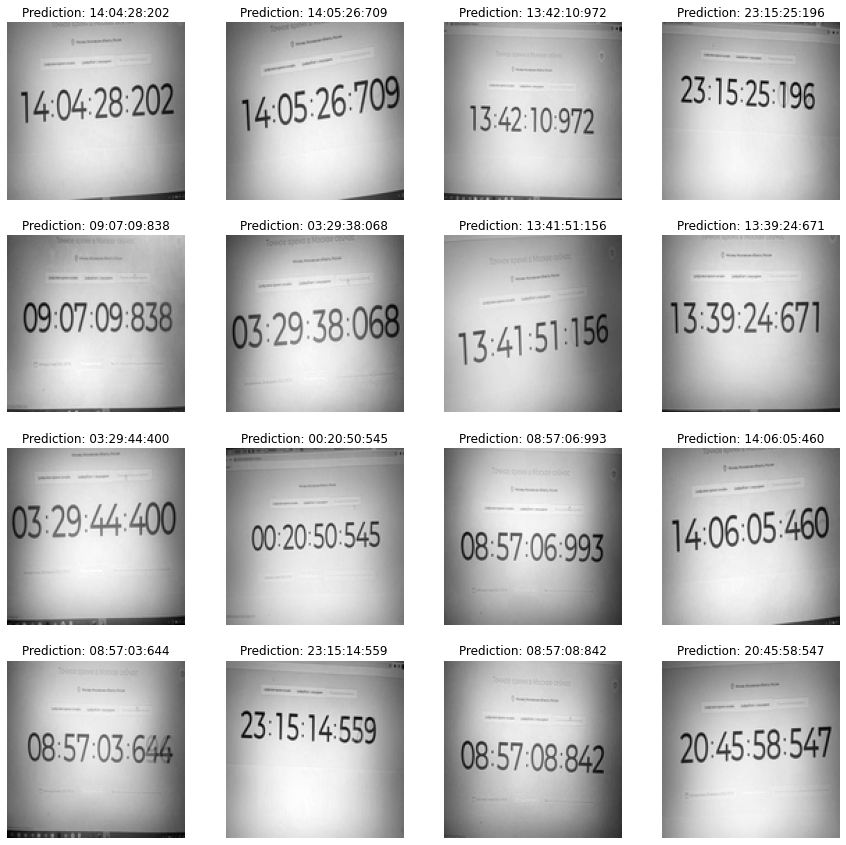

In [ ]:
#  Выведем несколько снимков, а также результаты предсказаний по ним, на экран
for batch in validation_dataset.take(1):   # Пробегаем по батчам в проверочном датасете
    batch_images = batch["image"]          # Отделяем изображения
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images) # Делаем предсказание
    pred_texts = decode_batch_predictions(preds)   # И декодируем его

    orig_texts = []
    for label in batch_labels:             # Пробегаем по лейблам в батче
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)           # Достаем значения и сохраняем в список

    _, ax = plt.subplots(4, 4, figsize=(15, 15))
    for i in range(len(pred_texts)):  # Пробегаем по всем предсказаниям
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T      # Преобразуем изображение в изначальный вид (Деномрмализуем, транспонируем)
        h1, h2, m1, m2, s1, s2, s3, s4, s5 = pred_texts[i][:9]
        pred_res = h1+h2+':'+m1+m2+':'+s1+s2+':'+s3+s4+s5
        title = f"Prediction: {pred_res}"   # Достаем значения из преобразованного в текст предсказания
        ax[i // 4, i % 4].imshow(img, cmap="gray") # И переводим в формат 'HH:MM:SS:sss'
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Тестовая выборка

Для окончательного тестирования взято несколько снимков, которых не было ни в проверочном ни в тренировочном датасетах

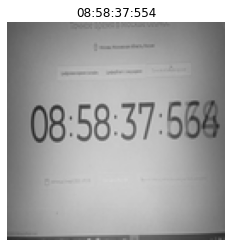

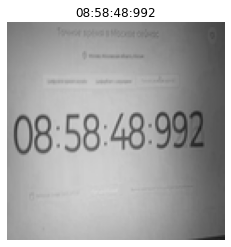

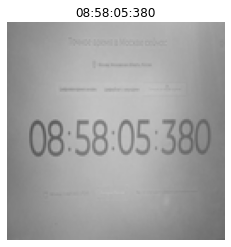

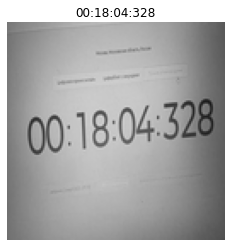

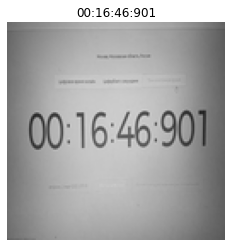

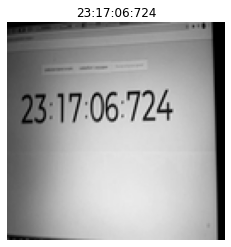

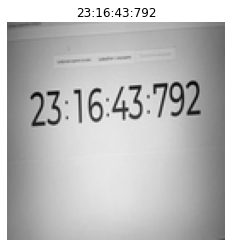

In [ ]:
for i in os.listdir('/content/drive/MyDrive/Colab_Files/Diplom/test/'):
  img_path = '/content/drive/MyDrive/Colab_Files/Diplom/test/' + i
  # Загружаем изображение
  img = tf.io.read_file(img_path)
  # Декодируем и переводим в одноканальный формат
  img = tf.io.decode_png(img, channels=1)
  # Нормализуем в диапазон от 0 до 1
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Подгоняем под нужные размеры
  img = tf.image.resize(img, [img_height, img_width])
  # Транспонируем для подачи в нейросеть
  img = tf.transpose(img, perm=[1, 0, 2])
      
  # Делаем предсказание по каждому снимку
  preds = prediction_model.predict(np.expand_dims(img, 0))
  # И преобразуем в читаемый формат
  pred_texts = decode_batch_predictions(preds)
  
  # Достаем значения из преобразованного в текст предсказания
  h1, h2, m1, m2, s1, s2, s3, s4, s5 = pred_texts[0][:9]
  # И переводим в формат 'HH:MM:SS:sss'
  plt.title(h1+h2+':'+m1+m2+':'+s1+s2+':'+s3+s4+s5)
  plt.imshow(cv2.imread(img_path))
  plt.axis('off')
  plt.show()

# Вывод

Точность оказалась впечатляющей. Даже блеклые, смазанные и сильно наклоненные снимки распознаны идеально. При этом модель работает очень быстро, даже на CPU.